<a href="https://colab.research.google.com/github/Ahmadrezauf/IML_Projects/blob/master/task_4/ns_main_project4_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pickle
import numpy as np
import os
import random
from numpy.random import seed

from google.colab import files
import io
import time
import random

import pdb
import cv2
import matplotlib.pyplot as plt

import keras.backend as K
from keras import Sequential
import tensorflow as tf

from keras.layers import Dense, Dropout, Activation, SimpleRNN, LSTM, Conv1D, MaxPooling1D, AveragePooling1D, Embedding
from keras.layers import BatchNormalization
from keras.layers import AlphaDropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda, Input, Layer

from keras.regularizers import l2

from keras.models import Model

from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from keras import initializers

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [ ]:
SEED = 93

# set seeds for recomputability

os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)
seed(SEED)

### Mounting drive and changing dir

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)
import os
workDir = '/content/drive/My Drive/IML/IML_Projects/task_4' #input('input the working directory: ')
os.chdir(workDir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Hyperparameters

In [ ]:
# desired image size for input to layer in format (w,h)
imgSize = (100,100)
# embedding size
emb_size = 64
# margin for triplet loss
alpha = 1

# Loading data

## Importing image tensor

In [ ]:
if os.path.exists('img_list.pickle'):
  print("Loading the image array")
  pickle_in = open( "img_list.pickle", "rb" )
  food_images = pickle.load(pickle_in)
  pickle_in.close()
  print("The image array was successfully loaded")
else:
  num_food_images = 10000
  path = 'food/'
  imageSize = (450,300)

  temp = np.zeros([imageSize[0],imageSize[1]])

  food_images = [temp]*num_food_images

  for indx in range(0, num_food_images):

    # reading in images and adding it to array
    fileName = f'{path}{indx:05d}.jpg'
    # color correct from BGR to RGB 
    img = cv2.imread(fileName)
    # resize image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # resize image
    img = cv2.resize(img, imageSize)
    # appending image
    food_images[indx] = img

    if indx%100 == 0:
      print(f'The progress is {round(indx/num_food_images*100,1)} %')

  saveY = input('Do you want to save the generated array? y/n')
  if saveY == 'y':
    pickle_out = open("img_list.pickle","wb")
    pickle.dump(food_images, pickle_out)
    pickle_out.close()
    print('The image array was successfully saved')
  else:
    print('The image array was NOT saved')

Loading the image array
The image array was successfully loaded


## Importing training and testing triplets

In [ ]:
D_train = pd.read_csv('train_triplets.txt', header = None, delim_whitespace=True)
D_test = pd.read_csv('test_triplets.txt', header = None, delim_whitespace=True)

train_triplets = np.array(D_train)
test_triplets = np.array(D_test)

num_train_triplets = np.shape(D_train)[0]
num_test_triplets = np.shape(D_test)[0]

## k-fold

In [ ]:
# splitting data triplets
k_fold = 100

from sklearn.model_selection import KFold
kf = KFold(n_splits = k_fold, shuffle=True, random_state=SEED)

X = np.array(D_train)

# get number of unique picture IDs in the training triplets
unique_train_img = np.unique(X)
# specify pseudo classification for split function
y = np.ones(unique_train_img.shape[0])

k_index = list(kf.split(unique_train_img,y))
k_index = np.array(k_index)
print(np.shape(k_index))

# visualize first k fold validation with training set
np.shape(unique_train_img[k_index[0][0]])

# find all the triplets that only contain the training images
def kfold_triplets(data, train_img):
  data_train_triplets = []
  data_val_triplets = []

  for i in range(0, len(data)):
    in_train_img = np.isin(data[i], train_img)
    if (np.all(in_train_img)):
      data_val_triplets = np.append(data_val_triplets, i)
      
    else:
      data_train_triplets = np.append(data_train_triplets, i)

  data_train = np.delete(data, data_train_triplets, 0)
  data_val = np.delete(data, data_val_triplets, 0)

  return data_train, data_val;


(100, 2)


In [ ]:
# defining data
fold = X[k_index[0][0],:]
validate = X[k_index[0][1],:]

xtrain, xval = kfold_triplets(X, k_index[0][0])

print(xtrain, np.shape(xtrain))
print(xval, np.shape(xval))

[[2461 3450 2678]
 [2299 2499 4987]
 [4663 1056 3029]
 ...
 [3255 4844 4334]
 [2136 4619  161]
 [2509 2552 3406]] (57677, 3)
[[2183 2123 3862]
 [ 220  166  579]
 [4998 2037   19]
 ...
 [3606 2378  549]
 [1742 4228 3899]
 [3158 2815 3249]] (1838, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


## function definitions

In [ ]:
def create_batch(fold, batch_size=256, toSize = (450,300), flatten = True):
    
    if flatten:
      x_anchors = np.zeros((batch_size, toSize[0]*toSize[1]*3))
      x_positives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
      x_negatives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
    else:
      x_anchors = np.zeros([batch_size, toSize[1], toSize[0], 3])
      x_positives = np.zeros([batch_size, toSize[1], toSize[0], 3])
      x_negatives = np.zeros([batch_size, toSize[1], toSize[0], 3])
          
    # get random samples from train triplets
    for i in range(0, batch_size):
        # preprocessing

        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, fold.shape[0]-1)
        triplet = fold[random_index]

        # reshaping, normalizing and flattening images --> this will take more time than pre-processed data, but will eliminate RAM issues

        x_anchor = cv2.resize(food_images[triplet[0]],toSize)/255.0
        x_positive = cv2.resize(food_images[triplet[1]],toSize)/255.0
        x_negative = cv2.resize(food_images[triplet[2]],toSize)/255.0

        if flatten:
          x_anchor = np.reshape(x_anchor, np.prod(x_anchor.shape))
          x_positive = np.reshape(x_positive, np.prod(x_positive.shape))
          x_negative = np.reshape(x_negative, np.prod(x_negative.shape))
             
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

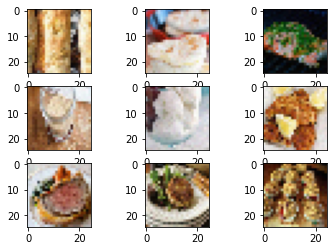

In [ ]:
# Example how to use function

tr = create_batch(fold, batch_size=3, toSize = (25,25), flatten = False)

for n in range(0,len(tr[0])):
  for i in range(0,3):
    plt.subplot(len(tr[0]),3, 3*n + i+1)
    plt.imshow(tr[i][n])

In [ ]:
def data_generator(fold, batch_size=256, toSize = (10,10), flatten=True):
    while True:
        x = create_batch(fold, batch_size, toSize, flatten)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

In [ ]:
def run_through(fold, toSize = (450,300), flatten = True):
    
    batch_size = len(fold)

    if flatten:
      x_anchors = np.zeros((batch_size, toSize[0]*toSize[1]*3))
      x_positives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
      x_negatives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
    else:
      x_anchors = np.zeros([batch_size, toSize[1], toSize[0], 3])
      x_positives = np.zeros([batch_size, toSize[1], toSize[0], 3])
      x_negatives = np.zeros([batch_size, toSize[1], toSize[0], 3])

    
    # get random samples from train triplets
    for i in range(0, len(fold)):
        # preprocessing

        # We need to find an anchor, a positive example and a negative example
        triplet = fold[i]

        # reshaping, normalizing and flattening images --> this will take more time than pre-processed data, but will eliminate RAM issues

        x_anchor = cv2.resize(food_images[triplet[0]],toSize)/255.0
        x_positive = cv2.resize(food_images[triplet[1]],toSize)/255.0
        x_negative = cv2.resize(food_images[triplet[2]],toSize)/255.0

        if flatten:
          x_anchor = np.reshape(x_anchor, np.prod(x_anchor.shape))
          x_positive = np.reshape(x_positive, np.prod(x_positive.shape))
          x_negative = np.reshape(x_negative, np.prod(x_negative.shape))
             
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative

        # yield [x_anchors, x_positives, x_negatives]
        
    return [x_anchors, x_positives, x_negatives]

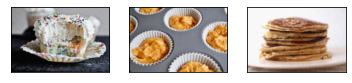

In [ ]:
def plot_triplets(examples, imgSize):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (imgSize[1], imgSize[0], 3)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

examples = create_batch(fold,1)
plot_triplets(examples,(450,300))

In [ ]:
# function for transforming predicted embeddings to required prediction 0 or 1
# anchor: dish A, positive: dish B, negative: dish C
# if distance A to B < A to C then A is more similar to B than to C -> return 1

def similar_dish(prediction):
  out = [0]*len(prediction)
  for idx, vec in enumerate(prediction):

    anchor, positive, negative = vec[:emb_size], vec[emb_size:2*emb_size], vec[2*emb_size:]
    positive_dist = np.mean(np.square(anchor - positive))
    negative_dist = np.mean(np.square(anchor - negative))

    if positive_dist < negative_dist:
      out[idx] = 1
    else:
      out[idx] = 0
  return out

In [ ]:
# less memory intense way of creating predictions
def predict_vec(fold, batch_size = 1000, toSize = (450,300), flatten = True):

  # define arrays
  if flatten:
    x_anchors = np.zeros((batch_size, toSize[0]*toSize[1]*3))
    x_positives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
    x_negatives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
  else:
    x_anchors = np.zeros([batch_size, toSize[1], toSize[0], 3])
    x_positives = np.zeros([batch_size, toSize[1], toSize[0], 3])
    x_negatives = np.zeros([batch_size, toSize[1], toSize[0], 3])

  predictions = []
  sample_in_batch = 0
  totlen=0

  # go through all the triplets in fold
  for i in range(0, len(fold)):

      # progress of prediction
      # if i%500 == 0:
        # print(f'The progress is {round(i/len(fold)*100,1)} %')

      # preprocessing

      # We need to find an anchor, a positive example and a negative example
      triplet = fold[i]

      # reshaping, normalizing and flattening images --> this will take more time than pre-processed data, but will eliminate RAM issues
      x_anchor = cv2.resize(food_images[triplet[0]],toSize)/255.0
      x_positive = cv2.resize(food_images[triplet[1]],toSize)/255.0
      x_negative = cv2.resize(food_images[triplet[2]],toSize)/255.0

      if flatten:
        x_anchor = np.reshape(x_anchor, np.prod(x_anchor.shape))
        x_positive = np.reshape(x_positive, np.prod(x_positive.shape))
        x_negative = np.reshape(x_negative, np.prod(x_negative.shape))

      # build array for prediciton
      x_anchors[sample_in_batch] = x_anchor
      x_positives[sample_in_batch] = x_positive
      x_negatives[sample_in_batch] = x_negative

      # go to next sample
      sample_in_batch = sample_in_batch + 1

      # if next sample would be in the next batch, predict for this batch

      if sample_in_batch >= batch_size or i == (len(fold)-1):
        # if i == (len(fold)-1):
          # print(f'End with batch sample {sample_in_batch}')
        # print(f'i is {i}, Predicting...')
        X = [x_anchors[0: sample_in_batch], x_positives[0: sample_in_batch], x_negatives[0:sample_in_batch]]

        vec = model.predict(X)
        similarity = similar_dish(vec)
        predictions.append(similarity)


        totlen = totlen + len(vec)

        # resart at the sample zero for the next batch
        sample_in_batch = 0



  pred_flat = []
  for li in predictions:
    for elem in li:
      pred_flat.append(elem)
  
  print(f' The length of the vector is: {totlen}')

  return pred_flat

In [ ]:
def flipp_validationset(X_validate):

  # initialize
  X_flipped = X_validate  
  set_length = len(X_validate)
  ground_truth = np.ones(set_length)
  
  num_flipped = int(set_length /2)
  flipped_indx = random.sample(range(set_length), num_flipped)

  # flip num_flipped randomly chosen
  for i in range(0,num_flipped):
    temp1 = X_validate[flipped_indx[i]][2]
    temp2 = X_validate[flipped_indx[i]][1]
    X_flipped[flipped_indx[i]][1] = temp1
    X_flipped[flipped_indx[i]][2] = temp2
    ground_truth[flipped_indx[i]] = 0


  return X_flipped, ground_truth

In [ ]:
# test for first validation set

X_validate = X[k_index[0][1],:]
# print(X_validate)

X_flipped, ground_truth = flipp_validationset(X_validate)
# print(X_flipped, ground_truth)

# Defining Model & network

## Embedding layer

In [ ]:
# import tensorflow as tf

# embedding_model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(emb_size, activation='relu', input_shape=(imgSize[0]*imgSize[1]*3,)),
#     tf.keras.layers.Dense(emb_size, activation='sigmoid')
# ])

# embedding_model.summary()

## Embedding layer with convolution

In [ ]:
# from keras import layers
# from keras.applications.resnet50 import ResNet50
# from keras import Input
# from keras import layers

# embedding_model = Sequential()
# embedding_model(Input(shape=(imgSize[1], imgSize[0], 3)))

# embedding_model.add(Conv2D(32, (3, 3)))
# embedding_model.add(Activation('relu'))
# embedding_model.add(MaxPooling2D(pool_size=(2, 2)))

# embedding_model.add(Conv2D(32, (3, 3)))
# embedding_model.add(Activation('relu'))
# embedding_model.add(MaxPooling2D(pool_size=(2, 2)))

# embedding_model.add(Conv2D(64, (3, 3)))
# embedding_model.add(Activation('relu'))
# embedding_model.add(MaxPooling2D(pool_size=(2, 2)))

# # embedding_model.add(layers.GlobalMaxPooling2D())

# embedding_model.add(layers.Flatten())

# embedding_model.add(layers.Dense(emb_size, activation='sigmoid'))


In [ ]:
# embedding_model.summary()

## Embedding Layer with ResNet

In [ ]:
from keras import layers
from keras.applications.resnet50 import ResNet50
from keras import Input
from keras import layers

input_resnet = Input(shape=(imgSize[1], imgSize[0], 3))
embedding_base = ResNet50(include_top=True, weights='imagenet', input_tensor=input_resnet, pooling=max)

# remove the output layer
# embedding_base.layers.pop()

resnet_output = embedding_base.output

# resnet_output = layers.Conv2D(32, 2, strides=2, activation="relu")(resnet_output)
# Adding a Global Average Pooling layer
# resnet_output = layers.GlobalMaxPooling2D()(resnet_output)
# resnet_output = layers.Flatten()(resnet_output)
resnet_output = layers.BatchNormalization()(resnet_output)
resnet_output = layers.Dense(emb_size, activation='relu')(resnet_output)
# resnet_output = layers.BatchNormalization()(resnet_output)
# resnet_output = layers.Dense(emb_size, activation='relu')(resnet_output)
# resnet_output = layers.BatchNormalization()(resnet_output)
# resnet_output = layers.Dense(emb_size, activation='relu')(resnet_output)
# resnet_output = layers.BatchNormalization()(resnet_output)
# resnet_output = layers.Dense(emb_size, activation='relu')(resnet_output)
# resnet_output = layers.BatchNormalization()(resnet_output)
# resnet_output = layers.Dense(emb_size, activation='relu')(resnet_output)

# Model to be trained
embedding_model = Model(inputs=embedding_base.input, outputs=resnet_output)

# not retrain the resnet model but only the last few layers and the subsequent added layers
#for layer in embedding_base.layers[5:]: 
#  layer.trainable = False

102858752/102853048 [==============================] - 1s 0us/step


## Embedding with VGG

In [ ]:
from keras import layers
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras import Input
from keras import layers

input_vgg = Input(shape=(imgSize[1], imgSize[0], 3))
# build the VGG16 network
embedding_base = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_vgg)
print('Model loaded.')

# remove the output layer
# embedding_base.layers.pop()

vgg_output = embedding_base.output

# resnet_output = layers.Conv2D(32, 2, strides=2, activation="relu")(resnet_output)
# Adding a Global Average Pooling layer
vgg_output = layers.GlobalMaxPooling2D()(vgg_output)
# vgg_output = layers.Flatten()(vgg_output)
# vgg_output = layers.BatchNormalization()(vgg_output)
# vgg_output = layers.AlphaDropout(rate = 0.2)(vgg_output)
# vgg_output = layers.Dense(emb_size, activation='relu')(vgg_output)
# vgg_output = layers.BatchNormalization()(vgg_output)
# vgg_output = layers.Dense(emb_size, activation='relu')(vgg_output)

# resnet_output = layers.BatchNormalization()(resnet_output)
# resnet_output = layers.Dense(emb_size, activation='relu')(resnet_output)
# resnet_output = layers.BatchNormalization()(resnet_output)
# resnet_output = layers.Dense(emb_size, activation='relu')(resnet_output)
# resnet_output = layers.BatchNormalization()(resnet_output)
# resnet_output = layers.Dense(emb_size, activation='relu')(resnet_output)

# Model to be trained
embedding_model = Model(inputs=embedding_base.input, outputs=vgg_output)

# not retrain the resnet model but only the last few layers and the subsequent added layers
for layer in embedding_base.layers[:]: 
 layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step
Model loaded.


In [ ]:
embedding_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

## Siamese network

In [ ]:
from keras import layers
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras import Input
from keras import layers
from keras import models
from keras.regularizers import l2
from keras import regularizers

def create_model():


  # input_resnet = Input(shape=(imgSize[1], imgSize[0], 3))
  # embedding_base = ResNet50(include_top=False, weights='imagenet', input_tensor=input_resnet, pooling='max')


  input_vgg = Input(shape=(imgSize[1], imgSize[0], 3))
  # build the VGG16 network
  embedding_base = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_vgg)
  # print('Model loaded.')
  vgg_output = embedding_base.output
  # vgg_output = layers.AlphaDropout(rate = 0.2, seed = SEED)(vgg_output)
  # vgg_output = layers.Flatten()(vgg_output)
  vgg_output = layers.GlobalMaxPooling2D()(vgg_output)
  # vgg_output = layers.AlphaDropout(rate = 0.6, seed = SEED)(vgg_output)
  vgg_output = layers.BatchNormalization()(vgg_output)
  # vgg_output = layers.Dense(emb_size, activation='relu', kernel_regularizer=l2(10))(vgg_output)
  # vgg_output = layers.Dense(1024, activation='relu')(vgg_output)
  # vgg_output = layers.AlphaDropout(rate = 0.2, seed = SEED)(vgg_output)
  # vgg_output = layers.Dense(1024, activation='relu')(vgg_output)
  # vgg_output = layers.Dense(emb_size, activation='sigmoid', kernel_regularizer=l2(10))(vgg_output)
  vgg_output = layers.Dense(emb_size, activation=None, kernel_regularizer=l2(0.001))(vgg_output)
  vgg_output = layers.Lambda(lambda x: K.l2_normalize(x,axis=-1))(vgg_output)
#Add a layer where input is the output of the  second last layer 
  # vgg_output = layers.Dense(emb_size, activation=None)(embedding_base.layers[-2].output)

  embedding_model = Model(inputs=embedding_base.input, outputs=vgg_output) 

# not retrain the resnet model but only the last few layers and the subsequent added layers 
  for layer in embedding_base.layers[:-4]: 
    layer.trainable = False

  input_anchor = layers.Input(shape=(imgSize[1],imgSize[0],3))
  input_positive = layers.Input(shape=(imgSize[1],imgSize[0],3))
  input_negative = layers.Input(shape=(imgSize[1],imgSize[0],3))

  embedding_model = Model(inputs=embedding_base.input, outputs=vgg_output)
  embedding_anchor = embedding_model(input_anchor)
  embedding_positive = embedding_model(input_positive)
  embedding_negative = embedding_model(input_negative)

  output = layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

  net = models.Model([input_anchor, input_positive, input_negative], output)


  net.summary()

  return net;

## Triplet loss

In [ ]:
import tensorflow as tf

def triplet_loss(y_true, y_pred):
    # anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    # positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    # negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    # triplet_loss = tf.maximum(positive_dist - negative_dist + alpha, 0.)
    # loss = tf.reduce_mean(triplet_loss)
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    negative_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    triplet_loss = tf.add(tf.subtract(positive_dist, negative_dist), alpha)  
    loss = tf.reduce_sum(tf.maximum(triplet_loss, 0.0)) 
    return loss

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
input_57 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
model_40 (Model)                (None, 64)           14749568    input_55[0][0]                   
                                                                 input_56[0][0]            

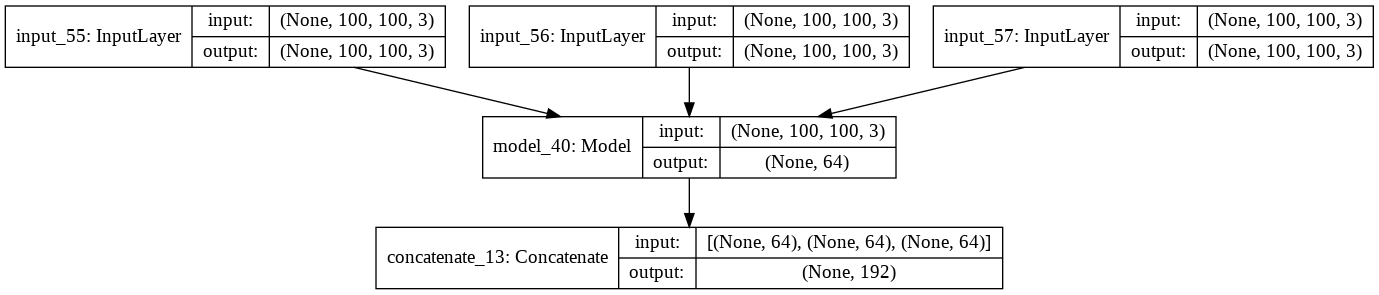

In [ ]:
import keras

model = create_model()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Training & saving network

In [ ]:
#from pca_plotter import PCAPlotter
import math
# 
batch_size = 32
epochs = 100
steps_per_epoch = math.floor(fold.shape[0]/batch_size)


# go through each fold (this will ake a long time!?)
for k in range(0, k_fold):
  X_train, X_validate = kfold_triplets(X, k_index[0][0])
  # X_train = X[k_index[k][0],:]
  # X_validate = X[k_index[k][1],:]

  model = None
  model = create_model()

  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,
  decay_steps=  steps_per_epoch * 1000,
  decay_rate=1, staircase=False)
  opt = tf.keras.optimizers.Adam(lr_schedule)

  early_stopping = [EarlyStopping(monitor='loss', patience=3)]

  # callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=50, mode="max", baseline = 0.6,
  #                          restore_best_weights = True, verbose = 1)
  #               ]

  # sgd =optimizers.SGD(lr=1e-3, momentum=0.9)
  model.compile(loss=triplet_loss, optimizer= opt)

  result =  model.fit(
      data_generator(X_train, batch_size, imgSize,flatten=False),
      steps_per_epoch=steps_per_epoch,
      callbacks = early_stopping,
      epochs=epochs
  )

  pr_val = predict_vec(X_validate, batch_size = 500, toSize = imgSize, flatten=False)
  # percentage accuracy
  perc_accuracy = round(np.sum(pr_val)/len(pr_val)*100,1)
  print(f'The accurate predictions for validation fold {k} is {perc_accuracy} %')

  pr_train = predict_vec(X_train, batch_size = 500, toSize = imgSize, flatten=False)
  perc_accuracy = round(np.sum(pr_train)/len(pr_train)*100,1)
  print(f'The accurate predictions for train fold {k} is {perc_accuracy} %')


  # break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Streaming output truncated to the last 5000 lines.
Epoch 1/100
154/154 [==============================] - 13s 84ms/step - loss: 29.0549
Epoch 2/100
154/154 [==============================] - 12s 80ms/step - loss: 27.3723
Epoch 3/100
154/154 [==============================] - 12s 80ms/step - loss: 25.7778
Epoch 4/100
154/154 [==============================] - 12s 80ms/step - loss: 24.8657
Epoch 5/100
154/154 [==============================] - 12s 80ms/step - loss: 24.2793
Epoch 6/100
154/154 [==============================] - 12s 81ms/step - loss: 23.3197
Epoch 7/100
154/154 [==============================] - 12s 81ms/step - loss: 22.6578
Epoch 8/100
154/154 [==============================] - 12s 81ms/step - loss: 21.9739
Epoch 9/100
154/154 [==============================] - 12s 80ms/step - loss: 21.9232
Epoch 10/100
154/154 [==============================] - 12s 81ms/step - loss: 22.0601
Epoch 11/100
154/154 [==============================] - 12s 81ms/step - loss: 20.9763
Epoch 12/100

In [ ]:
X_flipped, ground_truth = flipp_validationset(X_validate)
pr_val = predict_vec(X_flipped, batch_size = 500, toSize = imgSize, flatten=False)
# percentage accuracy
perc_accuracy = 100 - round(np.sum(abs(pr_val - ground_truth))/len(pr_val)*100,1)
print(f'The accurate predictions for validation fold is {perc_accuracy} %')


In [ ]:
# train on all triplets
model = None
model = create_model()

model.compile(loss=triplet_loss, optimizer= opt)

result =  model.fit(
      data_generator(X, batch_size, imgSize,flatten=False),
      steps_per_epoch=steps_per_epoch,
      callbacks = early_stopping,
      epochs=epochs
  )

NameError: ignored

In [ ]:
# saving as pickle object
# pickle_out = open("net.pickle","wb")
# pickle.dump(result, pickle_out)
# pickle_out.close()

import keras.losses
keras.losses.custom_loss = triplet_loss

from keras.models import load_model
import datetime
now = datetime.datetime.now()

# description = input('optional file description: ')
description = 'vgg_64embd_alphadropout_kernelreg'

filepath = f'{workDir}/models/{round(now.timestamp())}_sb_model_{description}.h5'
print(filepath)
model.save(filepath)

/content/drive/My Drive/IML/IML_Projects/task_4/models/1591464474_sb_model_vgg_64embd_alphadropout_kernelreg.h5


# Test predictions & save results

In [ ]:
# optionally loading a model
from tensorflow.keras.models import load_model

inp = input('Select model to run: ')

filepath = f'{workDir}/models/1591012695_sb_model_resnet_fulltrainable_batchnorm_32embedding.h5'

model_saved = load_model(filepath, custom_objects={'triplet_loss': triplet_loss})

Select model to run: 1591196543_sb_model_vgg_32embd


In [ ]:
pr_test = predict_vec(test_triplets, batch_size = 1000, toSize = imgSize, flatten=False)
print(pr_test)

 The length of the vector is: 59544
[1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 

In [ ]:
import datetime
now = datetime.datetime.now()

description = input('Add an optional description to the result file: ')
filepath = f'{workDir}/results/{round(now.timestamp())}_sb_result_{description}.txt'
np.savetxt(filepath, pr_test, fmt='%i', )

Add an optional description to the result file: kernel_reg


In [ ]:

+